# 02-2 사전 훈련된 모델로 전이 학습 수행하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/02-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## DenseNet

In [1]:
import keras
from keras import layers

2024-02-20 00:53:11.788923: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 00:53:14.055409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 00:53:14.055570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 00:53:14.418831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 00:53:15.155328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 00:53:15.156288: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
def dense_block(x, blocks):
    for _ in range(blocks):
        x1 = layers.BatchNormalization(epsilon=1e-5)(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(128, 1, use_bias=False)(x1)
        x1 = layers.BatchNormalization(epsilon=1e-5)(x1)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(32, 3, padding='same', use_bias=False)(x1)
        x = layers.Concatenate()([x, x1])
    return x

In [7]:
def transition_block(x):
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(int(x.shape[-1]/2), 1, use_bias=False)(x)
    x = layers.AveragePooling2D(2)(x)
    return x

In [8]:
img_input = layers.Input(shape=(224, 224, 3))

x = layers.ZeroPadding2D(padding=3)(img_input)
x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)
x = layers.ZeroPadding2D(padding=1)(x)
x = layers.MaxPooling2D(3, strides=2)(x)

for blocks in [6, 12, 24]:
    x = dense_block(x, blocks)
    x = transition_block(x)
x = dense_block(x, 16)

x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1000, activation='softmax')(x)
model = keras.Model(img_input, output)

In [9]:
from PIL import Image

dog_png = Image.open('images/dog.png')

In [10]:
import numpy as np
from keras.applications import densenet

dense_prep_dog = densenet.preprocess_input(np.array(dog_png))

In [11]:
densenet201 = keras.applications.DenseNet201()
predictions = densenet201.predict(dense_prep_dog[np.newaxis,:])
densenet.decode_predictions(predictions)

1/1 [==============================] - 3s 3s/step


[[('n02099712', 'Labrador_retriever', 0.52812),
  ('n04409515', 'tennis_ball', 0.1985789),
  ('n02104029', 'kuvasz', 0.06060526),
  ('n02111500', 'Great_Pyrenees', 0.027188241),
  ('n02099601', 'golden_retriever', 0.017613856)]]

## MobileNet

In [12]:
def depthwise_separable_block(inputs, filters, strides=1):
    if strides == 1:
        x = inputs
    else:
        x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(inputs)
    
    x = layers.DepthwiseConv2D(3, padding='same' if strides == 1 else 'valid',
                               strides=strides, use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU(max_value=6.0)(x)
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=1e-5)(x)
    x = layers.ReLU(max_value=6.0)(x)
    return x

In [13]:
img_input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, 3, padding='same', strides=2, use_bias=False)(img_input)
x = layers.BatchNormalization(epsilon=1e-5)(x)
x = layers.ReLU(max_value=6.0)(x)

for filters in (64, 128, 256):
    x = depthwise_separable_block(x, filters)
    x = depthwise_separable_block(x, filters*2, strides=2)
for _ in range(5):
    x = depthwise_separable_block(x, 512)
x = depthwise_separable_block(x, 1024, strides=2)
x = depthwise_separable_block(x, 1024)

x = layers.GlobalAveragePooling2D(keepdims=True)(x)
x = layers.Dropout(0.001)(x)
x = layers.Conv2D(1000, 1, padding='same')(x)
x = layers.Reshape((1000,))(x)
output = layers.Activation('softmax')(x)

model = keras.Model(img_input, output)

In [14]:
from keras.applications import mobilenet

dense_prep_dog = mobilenet.preprocess_input(np.array(dog_png))
model = keras.applications.MobileNet()
predictions = model.predict(dense_prep_dog[np.newaxis,:])
mobilenet.decode_predictions(predictions)

1/1 [==============================] - 0s 321ms/step


[[('n02099712', 'Labrador_retriever', 0.40903977),
  ('n02104029', 'kuvasz', 0.18954588),
  ('n02110341', 'dalmatian', 0.14881629),
  ('n02111500', 'Great_Pyrenees', 0.042762574),
  ('n02099601', 'golden_retriever', 0.027608037)]]

## EfficientNet

In [31]:
[1.0 / math.sqrt(stddev) for stddev in [0.229, 0.224, 0.225]]

[2.0896918976428642, 2.1128856368212916, 2.1081851067789197]

In [41]:
import tensorflow as tf
import tensorflow_hub as hub
import math

m = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255.0, input_shape=(224, 224, 3)),
    # layers.Normalization(),
    # layers.Rescaling([1.0 / math.sqrt(stddev) for stddev in [0.229, 0.224, 0.225]]),
    hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1")
])
# m.build([None, 224, 224, 3])

In [32]:
np.array(dog_png).shape

(224, 224, 3)

In [42]:
predictions = m.predict(np.array(dog_png)[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 1s 534ms/step


[[('n02099712', 'Labrador_retriever', 0.36829516),
  ('n02104029', 'kuvasz', 0.19339864),
  ('n02099601', 'golden_retriever', 0.06145809),
  ('n02111500', 'Great_Pyrenees', 0.05779675),
  ('n02095889', 'Sealyham_terrier', 0.017902764)]]

In [20]:
from keras.applications import efficientnet

m2 = keras.applications.EfficientNetB0()
predictions = m2.predict(np.array(dog_png)[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 1s 972ms/step


[[('n02099712', 'Labrador_retriever', 0.36829546),
  ('n02104029', 'kuvasz', 0.19339833),
  ('n02099601', 'golden_retriever', 0.06145811),
  ('n02111500', 'Great_Pyrenees', 0.0577968),
  ('n02095889', 'Sealyham_terrier', 0.01790276)]]

In [24]:
m2.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2

In [ ]:
keras.applications.MobileNetV3Small().summary()

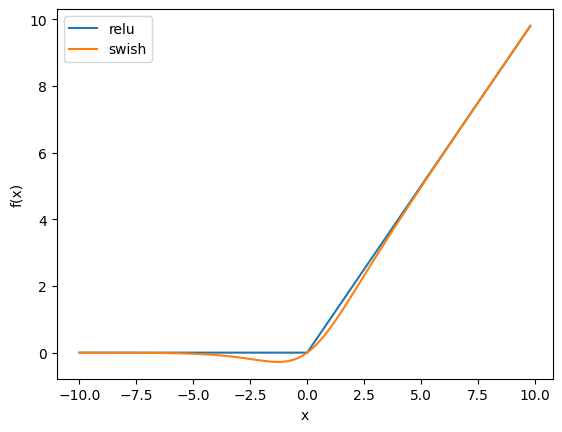

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-10, 10, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, x * expit(x), label='swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [8]:
-100 * expit(-100)

-3.720075976020836e-42

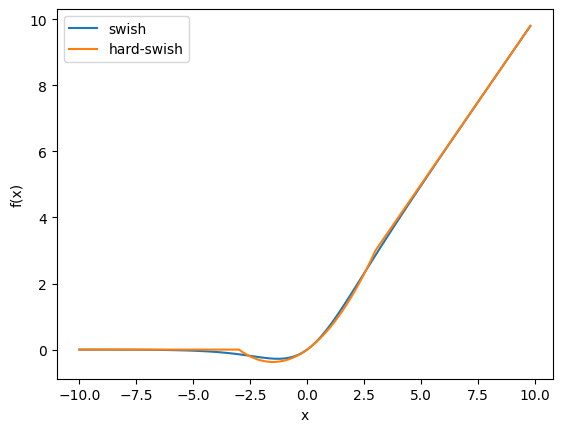

In [13]:
def relu6(x):
    return np.minimum(np.maximum(x, 0), 6)

x = np.arange(-10, 10, 0.2)

plt.plot(x, x * expit(x), label='swish')
plt.plot(x, x * relu6(x+3)/6, label='hard-swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [2]:
def inv_res_block(inputs, filters_out, kernel_size, strides, dropout_rate, expand_ratio):
    # 팽창 단계
    filters_in = inputs.shape[-1]
    filters = filters_in * expand_ratio
    if expand_ratio > 1:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
    else:
        x = inputs
    
    # 깊이별 분리 합성곱
    if strides == 2:
        x = layers.ZeroPadding2D(padding=padding_size(x.shape, kernel_size))(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, use_bias=False, 
                               padding='same' if strides == 1 else 'valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # SE 블록
    se_input = x
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Conv2D(filters_in * 0.25, 1, padding='same', activation='swish')(x)
    x = layers.Conv2D(filters, 1, padding='same', activation='sigmoid')(x)
    x = layers.multiply([se_input, x])

    # 출력 단계
    x = layers.Conv2D(filters_out, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if strides == 1 and filters_in == filters_out:
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, noise_shape=(None, 1, 1, 1))(x)
            x = layers.add([x, inputs])
    return x

In [3]:
def padding_size(input_size, kernel_size):
    # 입력 크기가 짝수이면 아래쪽과 오른쪽만 패딩합니다.
    padding = kernel_size // 2
    if input_size[1] % 2 == 0:
        return ((padding - 1, padding),
                (padding - 1, padding))
    else:
        return padding

In [5]:
import numpy as np

def round_repeats(repeats, depth):
    """repeats * depth 보다 큰 정수를 반환합니다"""
    return int(math.ceil(repeats * depth))

def round_filters(filters, width):
    """filters * width 보다 크고 8의 배수가 되도록 만듭니다"""
    filters *= width
    new_filters = max(8, int(filters + 4) // 8 * 8)
    if new_filters < 0.9 * filters:
        new_filters += 8
    return int(new_filters)

In [6]:
blocks_args = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "strides": 1
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "strides": 1
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "strides": 1
    },
]

In [7]:
import math

width = 1.0
depth = 1.0
img_input = layers.Input(shape=(224, 224, 3))

x = layers.Rescaling(1.0 / 255.0)(img_input)
x = layers.Normalization()(x)
x = layers.Rescaling([1.0 / math.sqrt(stddev) for stddev in (0.229, 0.224, 0.225)])(x)
x = layers.ZeroPadding2D(padding=padding_size(x.shape, 3))(x)
x = layers.Conv2D(round_filters(32, width), 3, strides=2, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

In [8]:
filter_expand_ratio = 1
block_count = 0
total_blocks = float(sum(round_repeats(args["repeats"], depth) for args in blocks_args))
for args in blocks_args:
    # depth에 따라 블록의 입력과 출력 필터를 늘립니다.
    filters_out = round_filters(args['filters_out'], width)
    strides = args["strides"]
    for j in range(round_repeats(args["repeats"], depth)):
        # 반복의 첫 번째 블록을 제외한 나머지 블록은 스트라이드 1입니다.
        if j > 0:
            strides = 1
        dropout_rate = 0.2 * block_count / total_blocks
        x = inv_res_block(x, filters_out, 
                              args['kernel_size'], strides, 
                              dropout_rate, filter_expand_ratio)
        block_count += 1
    filter_expand_ratio = 6

In [9]:
x = layers.Conv2D(round_filters(1280, width), 1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1000, activation='softmax')(x)

model = keras.Model(img_input, output)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'] 